In [1]:
# Quick hack to fix local imports for the generated files
import os
import sys
module_path = os.path.abspath(os.path.join('../generated'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import platform
import subprocess
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import OutbreakSim.Model.Model as gen_model
import OutbreakSim.Model.Vec2

In [3]:
synthetic_environments = {}

In [4]:
def load_reports(report_dir):
    with open(report_dir + "parameters.json") as f:
        parameters = json.load(f)
    with open(report_dir + "concluding.json") as f:
        concluding = json.load(f)
        
    intermediary = pd.read_csv(report_dir + "intermediary.csv")
    
    return (parameters, intermediary, concluding)

In [5]:
def load_synthetic_environment(data_file_path):
    if data_file_path in synthetic_environments:
        return synthetic_environments[data_file_path]
    
    data_file_path = Path(data_file_path)
    if not data_file_path.exists() and platform.system() == 'Linux':
        # Try to convert the path to a WSL path
        data_file_path = Path(subprocess.run(['wslpath', '-a', data_file_path], capture_output=True).stdout.decode().strip())
    
    buf = open(data_file_path, 'rb').read()
    model = gen_model.Model.GetRootAsModel(buf, 0)
    synthetic_environments[data_file_path] = model
    return model

In [6]:
def parse_reports(report_dir):
    parameters, intermediary, concluding = load_reports(report_dir)
    synth_env = load_synthetic_environment(concluding['synthetic_environment_path'])
    
    intermediary['day'] = intermediary['time_step'] / parameters['time_steps_per_day']
    intermediary = intermediary.set_index('day')
    intermediary.drop('time_step', axis='columns', inplace=True)
    intermediary.rename({
        'num_susceptible': 'Susceptible', 
        'num_exposed': 'Exposed', 
        'num_infectious': 'Infectious', 
        'num_recovered': 'Recovered'}, 
        axis='columns', inplace=True)
    
    return (synth_env, parameters, intermediary, concluding)

In [7]:
def calc_area(syth_env):
    bounds_min = synth_env.Bounds().Min(OutbreakSim.Model.Vec2.Vec2())
    bounds_max = synth_env.Bounds().Max(OutbreakSim.Model.Vec2.Vec2())
    
    return (bounds_max.X() - bounds_min.X()) * (bounds_max.Y() - bounds_min.Y())

def parse_end_stats(index_name, synth_env, parameters, concluding):    
    return pd.DataFrame.from_records([{
        'num_agents': synth_env.Agents().AgeLength(),
        'area': calc_area(synth_env),
        'total_exec_time': concluding['simulation_execution_time_in_secs'],
        'steps_per_day': parameters['time_steps_per_day'],
        'total_steps': concluding['total_time_steps'],
    }], index=[index_name])

In [8]:
def graph_infections(intermediary, title):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_ylabel('Number of People')
    ax.set_title(title)
    intermediary.plot(ax=ax)
    return fig

In [13]:
def load_iterations(report_dir, iterations):
    synth_envs = []
    parameters = []
    intermediaries = []
    concludings = []
    for i in range(iterations):
        synth_env, params, intermediary, concluding = parse_reports(f"{report_dir}/{i}/")
        parameters.append(params)
        intermediaries.append(intermediary)
        concludings.append(concluding)
        
    return (synth_envs, parameters, intermediaries, concludings)

In [32]:
def graph_seir_iterations(intermediaries):
    fig, ax = plt.subplots()
    for intermediary in intermediaries:
        ax2 = ax.twinx()
        ax2.axis('off')
        ax2.sharey(ax)
        intermediary.plot(ax=ax2)

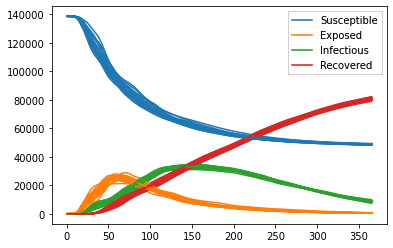

In [52]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/isle_of_wight/", 20)
graph_seir_iterations(intermediaries)

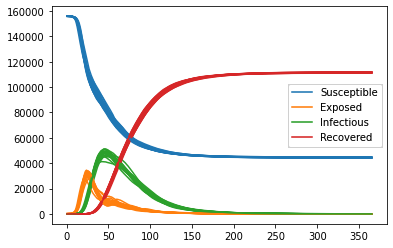

In [53]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/isle_of_dogs/", 20)
graph_seir_iterations(intermediaries)

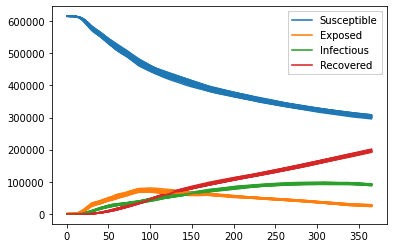

In [54]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/devon/", 20)
graph_seir_iterations(intermediaries)

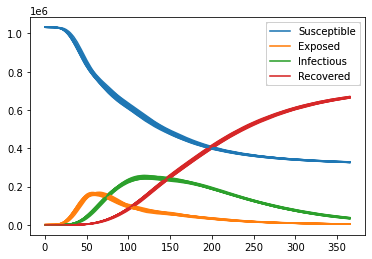

In [55]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/greater_manchester/", 20)
graph_seir_iterations(intermediaries)

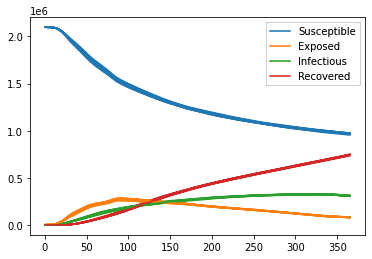

In [56]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/wales/", 20)
graph_seir_iterations(intermediaries)

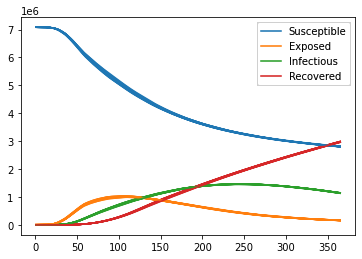

In [58]:
synth_envs, parameters, intermediaries, concludings = load_iterations("../../reports/london_se_commuter_ring/", 20)
graph_seir_iterations(intermediaries)

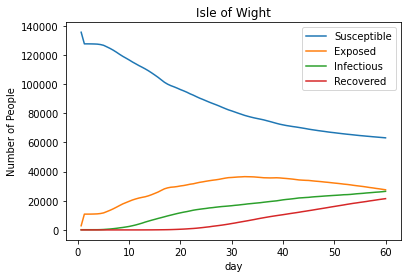

In [15]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/isle_of_wight/0/")
fig = graph_infections(intermediary, 'Isle of Wight')
# fig.savefig('graphs/isle_of_wight', bbox_inches='tight', pad_inches=0.1)
stats = parse_end_stats('isle_of_wight', synth_env, parameters, concluding)
del synth_env, parameters, intermediary, concluding, fig

In [ ]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/isle_of_dogs/0/")
fig = graph_infections(intermediary, 'Isle of Dogs')
# fig.savefig('graphs/isle_of_dogs', bbox_inches='tight', pad_inches=0.1)
stats = stats.append(parse_end_stats('isle_of_dogs', synth_env, parameters, concluding))
del synth_env, parameters, intermediary, concluding, fig

In [ ]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/greater_manchester/0/")
fig = graph_infections(intermediary, ' Greater Manchester')
fig.savefig('graphs/greater_manchester', bbox_inches='tight', pad_inches=0.1)
# stats = stats.append(parse_end_stats('greater_manchester', synth_env, parameters, concluding))
del synth_env, parameters, intermediary, concluding, fig

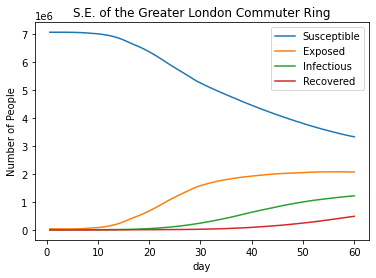

In [39]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/london_se_commuter_ring/0/")
fig = graph_infections(intermediary, 'S.E. of the Greater London Commuter Ring')
# fig.savefig('graphs/london_se_commuter_ring', bbox_inches='tight', pad_inches=0.1)
stats = stats.append(parse_end_stats('london_se_commuter_ring', synth_env, parameters, concluding))
del synth_env, parameters, intermediary, concluding, fig

In [ ]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/wales/0/")
fig = graph_infections(intermediary, 'Wales')
# fig.savefig('graphs/wales', bbox_inches='tight', pad_inches=0.1)
stats = stats.append(parse_end_stats('wales', synth_env, parameters, concluding))
del synth_env, parameters, intermediary, concluding, fig

In [ ]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/devon/0/")
fig = graph_infections(intermediary, 'Devon')
# fig.savefig('graphs/devon', bbox_inches='tight', pad_inches=0.1)
stats = stats.append(parse_end_stats('devon', synth_env, parameters, concluding))
del synth_env, parameters, intermediary, concluding, fig

In [ ]:
stats['exec_time_per_step'] = stats['total_exec_time'] / stats['total_steps']
stats['pop_density'] = stats['num_agents'] / stats['area'] 

In [ ]:
stats

In [ ]:
stats[['num_agents', 'exec_time_per_step']].plot(x='exec_time_per_step', y='num_agents', kind='scatter')

In [ ]:
stats['total_exec_time'] / stats['num_agents']

In [ ]:
stats[['pop_density', 'exec_time_per_step']].plot(x='exec_time_per_step', y='pop_density', kind='scatter')